In [34]:
import torch
from torch import nn
from src.data import get_data
from src.models import get_encoder, get_decoder
from src.utils import softclip
from src.hessian import sampler
import yaml
from copy import deepcopy
from torch.nn.utils import parameters_to_vector, vector_to_parameters

def get_model(encoder, decoder):
    
    net = deepcopy(encoder.encoder._modules)
    decoder = decoder.decoder._modules
    max_ = max([int(i) for i in net.keys()])
    for i in decoder.keys():
        net.update({f"{max_+int(i) + 1}": decoder[i]})

    return nn.Sequential(net)

In [35]:
path_ae = "../weights/mnist/ae_[use_var_dec=False]"
with open(f"{path_ae}/config.yaml") as file:
    config = yaml.full_load(file)
ae_encoder = get_encoder(config, latent_size=2)
ae_encoder.load_state_dict(torch.load(f"{path_ae}/encoder.pth"))


path_mcae = "../weights/mnist/mcdropout_ae"
with open(f"{path_mcae}/config.yaml") as file:
    config = yaml.full_load(file)
mcae_encoder = get_encoder(config, latent_size=2, dropout=config["dropout_rate"])
mcae_encoder.load_state_dict(torch.load(f"{path_mcae}/encoder.pth"))

path_vae = "../weights/mnist/vae_[use_var_dec=False]"
with open(f"{path_vae}/config.yaml") as file:
    config = yaml.full_load(file)
vae_encoder_mu = get_encoder(config, latent_size=2)
vae_encoder_mu.load_state_dict(torch.load(f"{path_vae}/mu_encoder.pth"))
vae_encoder_var = get_encoder(config, latent_size=2)
vae_encoder_var.load_state_dict(torch.load(f"{path_vae}/var_encoder.pth"))

path_lae = "../weights/mnist/lae_elbo/[backend_layer]_[approximation_exact]_[no_conv_True]_[train_samples_10]_/"
with open(f"{path_lae}/config.yaml") as file:
    config = yaml.full_load(file)
lae_encoder = get_encoder(config, latent_size=2)
lae_decoder = get_decoder(config, latent_size=2)
lae_net = get_model(lae_encoder, lae_decoder).eval()
lae_net.load_state_dict(torch.load(f"{path_lae}/net.pth"))
hessian_approx = (
    sampler.BlockSampler()
    if config["approximation"] == "block"
    else sampler.DiagSampler()
)
h = torch.load(f"{path_lae}/hessian.pth")
sigma_q = hessian_approx.invert(h).cpu()

In [36]:
_, val_dataloader = get_data("mnist")
images, labels = [ ], [ ]

for batch in val_dataloader:
    x, y = batch
    images.append(x)
    labels.append(y)
images = torch.cat(images, 0)
labels = torch.cat(labels, 0)

n_select = 20 # select this many datapoints from each class

selected_images = torch.zeros(10*n_select, 1, 28, 28)
selected_labels = torch.zeros(10*n_select,)
eval_set_images = torch.zeros(images.shape[0]-10*n_select, 1, 28, 28)
eval_set_labels = torch.zeros(images.shape[0]-10*n_select, )

count = 0
for i in range(10):
    idx = torch.where(labels == i)[0]
    n = len(idx)
    rand_idx = torch.randperm(n)

    selected_images[i*n_select:(i+1)*n_select] = images[idx[rand_idx[:n_select]]]
    selected_labels[i*n_select:(i+1)*n_select] = labels[idx[rand_idx[:n_select]]]
    eval_set_images[count:count+len(rand_idx[n_select:])] = images[idx[rand_idx[n_select:]]]
    eval_set_labels[count:count+len(rand_idx[n_select:])] = labels[idx[rand_idx[n_select:]]]

    count += len(rand_idx[n_select:])

In [43]:
def get_encoding_ae(data, n=1):
    return ae_encoder(data)

print('standard ae')
print(get_encoding_ae(images[:1]))

def get_encoding_mcae(data, n=1):
    return torch.cat([mcae_encoder(data) for _ in range(n)], 0)

print('monte-carlo ae')
print(get_encoding_mcae(images[:1], n=2))

def get_encoding_vae(data, n=1):
    mu = vae_encoder_mu(data)
    sigma = torch.exp(softclip(vae_encoder_var(data), min=-3))
    return torch.cat([mu + torch.randn_like(sigma) * sigma for _ in range(n)])

print('vae')
print(get_encoding_vae(images[:1], n=2))

def get_encoding_lae(data, n=1):
    embeddings = [ ]
    def fw_hook_get_latent(module, input, output):
        embeddings.append(output.detach().cpu())
    temp = deepcopy(lae_net)
    temp[5].register_forward_hook(fw_hook_get_latent)

    mu_q = parameters_to_vector(temp.parameters())
    sample = hessian_approx.sample(mu_q, sigma_q, n_samples=n)
    for i in range(n):
        vector_to_parameters(sample[i], temp.parameters())
        _ = temp(data)
    return torch.cat(embeddings, 0)

print('lae')
print(get_encoding_lae(images[:1], n=2))

standard ae
tensor([[ 0.6679, 11.1749]], grad_fn=<AddmmBackward0>)
monte-carlo ae
tensor([[  0.4650, -15.8803],
        [  0.9550, -15.1139]], grad_fn=<CatBackward0>)
vae
tensor([[-1.2401,  0.9685],
        [-1.4112,  0.9531]], grad_fn=<CatBackward0>)
lae
tensor([[ 1.4764, -1.1890],
        [ 1.4664, -1.2565]])


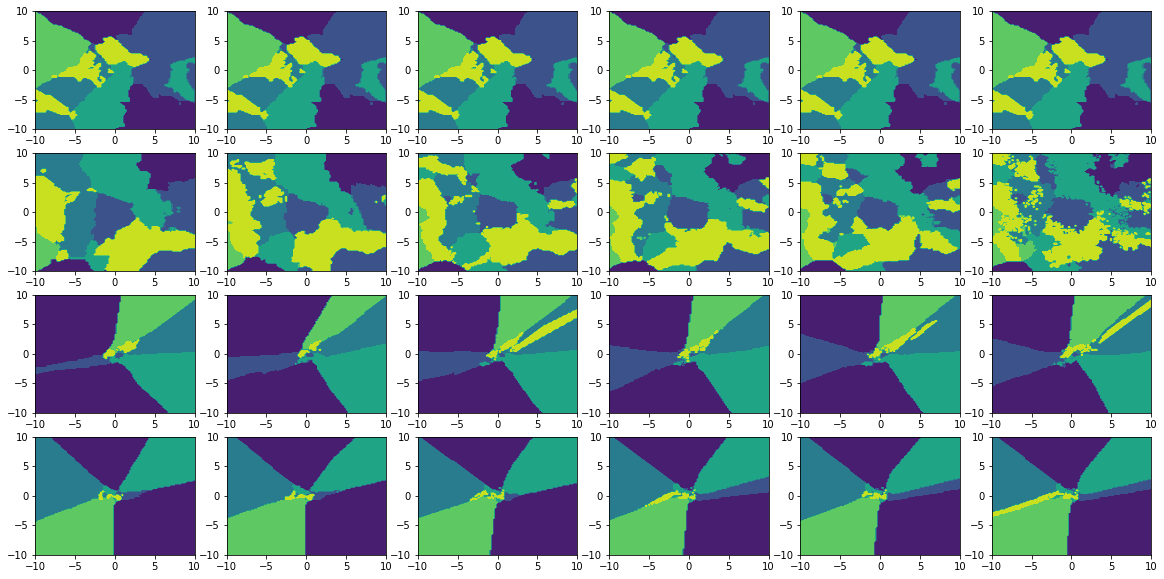

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

z_grid = torch.meshgrid([torch.linspace(-10, 10, 100), torch.linspace(-10, 10, 100)])
z_grid = torch.stack(z_grid, 0).reshape(2, -1).T

names = ['ae', 'mcae', 'vae', 'lae']
scales = [1, 2, 5, 10, 20, 100]
fig, ax = plt.subplots(4, len(scales), figsize=(20, 10))
res_mean, res_std = [], []
reps = 5
for i, (name, encoder) in enumerate(zip(names, [get_encoding_ae, get_encoding_mcae, get_encoding_vae, get_encoding_lae])):
    eval_data = torch.cat([encoder(d) for d in eval_set_images], 0)
    res_mean.append([ ])
    res_std.append([ ])
    for j, s in enumerate(scales):
        res = [ ]
        for r in range(reps):
            train_data = torch.cat([encoder(d, s) for d in selected_images], 0)
            train_labels = selected_labels.repeat_interleave(s) if name != 'ae' else selected_labels
            classifier = GridSearchCV(
                KNeighborsClassifier(),
                {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
                cv=3,
                refit=True,
            )
            classifier.fit(train_data.detach().numpy(), train_labels.detach().numpy())
            preds = classifier.predict(eval_data.detach().numpy())
            acc = (preds == eval_set_labels.numpy()).mean()
            res.append(acc)

        res_mean[-1].append(np.mean(res))
        res_std[-1].append(np.std(res))

        preds_grid = classifier.predict(z_grid.numpy())
        ax[i, j].contourf(
            z_grid[:,0].reshape(100, 100),
            z_grid[:,1].reshape(100, 100),
            preds_grid.reshape(100, 100)
        )
res_mean = np.asarray(res_mean)
res_std = np.asarray(res_std)

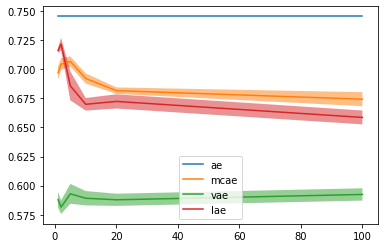

In [45]:
fig = plt.figure()
for i, name in enumerate(names):
    plt.plot(scales, res_mean[i], label=name)
    plt.fill_between(scales, res_mean[i] + res_std[i], res_mean[i] - res_std[i], alpha=0.5)

plt.legend()